
## *Dataset*

***

|feature              | description|
| -------------------- | -----------------------------------------------------------------------------------------|
| cap-diameter         | \-|
| cap-shape            | bell=b, conical=c, convex=x, flat=f, knobbed=k, sunken=s|
| cap-surface          | fibrous=f, grooves=g, scaly=y, smooth=s|
| cap-color            | brown=n, buff=b, cinnamon=c, gray=g, green=r, pink=p, purple=u, red=e, white=w, yellow=y|
| does-bruise-or-bleed | true=t, false=f|
| gill-attachment      | attached=a, descending=d, free=f, notched=n|
| gill-spacing         | close=c, crowded=w, distant=d|
| gill-color           | black=k, brown=n, buff=b, chocolate=h, gray=g, green=r, orange=o, pink=p, purple=u, red=e, white=w, yellow=y |
| stem-height          | \-|
| stem-width           | \-|
| stem-root            | bulbous=b, club=c, cup=u, equal=e, rhizomorphs=z,rooted=r, missing=?|
| stem-surface         | fibrous=f, scaly=y, silky=k, smooth=s|
| stem-color           | brown=n, buff=b, cinnamon=c, gray=g, orange=o, pink=p,red=e, white=w, yellow=y|
| veil-type            | partial=p, universal=u|
| veil-color           | brown=n, orange=o, white=w, yellow=y|
| has-ring             | true=t, false=f|
| ring-type            | cobwebby=c, evanescent=e,flaring=f,large=l, none=n,pendant=p,sheathing=s,zone=z|
| spore-print-color    | black=k, brown=n, buff=b, chocolate=h, green=r, orange=o, purple=u, white=w, yellow=y|
| habitat              | abundant=a, clustered=c, numerous=n, scattered=s, several=v, solitary=y|
| season               | winter=w, spring=s, summer=u, autumn=a |

## 1. Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings

In [2]:
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

warnings.filterwarnings('ignore')

## 2. Loading data

In [3]:
train_df = pd.read_csv('/kaggle/input/playground-series-s4e8/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s4e8/test.csv')

In [4]:
print(f'Train df shape is: {train_df.shape}.')
print(f'Memory consumption is {(train_df.memory_usage().sum() / 1024**2): .2f} MB.')
print(f'Test df shape is: {test_df.shape}.')
print(f'Memory consumption is: {(test_df.memory_usage().sum() / 1024**2): .2f} MB.')

Train df shape is: (3116945, 22).
Memory consumption is  523.17 MB.
Test df shape is: (2077964, 21).
Memory consumption is:  332.93 MB.


In [5]:
df = pd.concat([train_df, test_df], axis=0)

## 3. Understanding the data

In [6]:
df.head(3)

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,4.51,15.39,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,p,4.51,x,h,o,f,a,c,n,4.79,6.48,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,2,e,6.94,f,s,b,f,x,c,w,6.85,9.93,NaN,s,n,NaN,NaN,f,f,NaN,l,w


In [7]:
df.tail(3)

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
2077961,5194906,NaN,5.73,x,e,e,f,a,NaN,w,6.16,9.74,NaN,NaN,y,NaN,w,t,z,NaN,d,a
2077962,5194907,NaN,5.03,b,g,n,f,a,d,g,6.00,3.46,NaN,s,g,NaN,NaN,f,f,NaN,d,a
2077963,5194908,NaN,15.51,f,NaN,w,f,d,c,y,2.69,17.71,NaN,NaN,w,NaN,NaN,f,f,NaN,d,w


In [8]:
df.describe()

,id,cap-diameter,stem-height,stem-width
count,5.194909e+06,5.194898e+06,5.194908e+06,5.194909e+06
mean,2.597454e+06,6.308386e+00,6.347604e+00,1.115162e+01
std,1.499641e+06,4.668963e+00,2.699444e+00,8.097359e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.298727e+06,3.320000e+00,4.670000e+00,4.970000e+00
50%,2.597454e+06,5.740000e+00,5.880000e+00,9.650000e+00
75%,3.896181e+06,8.240000e+00,7.410000e+00,1.562000e+01
max,5.194908e+06,6.070000e+02,8.872000e+01,1.029100e+02


In [9]:
print(f'Number of duplicates in train set: {train_df.duplicated().sum()}.')
print(f'Number of duplicates in test set: {test_df.duplicated().sum()}.')

Number of duplicates in train set: 0.
Number of duplicates in test set: 0.


In [10]:
print('Percentage of missing values in train set:')
train_df.isna().sum() / len(train_df) * 100

Percentage of missing values in train set:


id                       0.000000
class                    0.000000
cap-diameter             0.000128
cap-shape                0.001283
cap-surface             21.528227
cap-color                0.000385
does-bruise-or-bleed     0.000257
gill-attachment         16.809280
gill-spacing            40.373988
gill-color               0.001829
stem-height              0.000000
stem-width               0.000000
stem-root               88.452732
stem-surface            63.551362
stem-color               0.001219
veil-type               94.884350
veil-color              87.936970
has-ring                 0.000770
ring-type                4.134818
spore-print-color       91.425482
habitat                  0.001444
season                   0.000000
dtype: float64

In [11]:
print('Percentage of missing values in test set:')
test_df.isna().sum() / len(test_df) * 100

Percentage of missing values in test set:


id                       0.000000
cap-diameter             0.000337
cap-shape                0.001492
cap-surface             21.506821
cap-color                0.000626
does-bruise-or-bleed     0.000481
gill-attachment         16.834796
gill-spacing            40.404694
gill-color               0.002358
stem-height              0.000048
stem-width               0.000000
stem-root               88.452543
stem-surface            63.595327
stem-color               0.001011
veil-type               94.878689
veil-color              87.880445
has-ring                 0.000914
ring-type                4.148051
spore-print-color       91.417224
habitat                  0.001203
season                   0.000000
dtype: float64

I made a decision to delete columns with high percentage of missing values.
* gill-spacing
* stem-root
* stem-surface
* veil-type
* veil-color
* spore-print-color

And 'id' column.


In [12]:
cols_to_drop = ['id', 'gill-spacing', 'stem-root', 'stem-surface', 'veil-type', 'veil-color', 'spore-print-color']

df = df.drop(cols_to_drop, axis=1)

In [13]:
df = df[['cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
        'does-bruise-or-bleed', 'gill-attachment', 'gill-color', 'stem-height',
        'stem-width', 'stem-color', 'has-ring', 'ring-type', 'habitat',
        'season', 'class']]

## 4. Data cleaning

In [14]:
print('Number of uniques values in df\'s columns:')
df.nunique()

Number of uniques values in df's columns:


cap-diameter            4145
cap-shape                108
cap-surface              114
cap-color                109
does-bruise-or-bleed      29
gill-attachment          117
gill-color                86
stem-height             2858
stem-width              6194
stem-color                88
has-ring                  26
ring-type                 47
habitat                   65
season                     4
class                      2
dtype: int64

In [15]:
print('Feature values:')
for col in df.select_dtypes(include='object').columns:
    print(df[col].value_counts())
    print('--------------------')

Feature values:
cap-shape
x               2393975
f               1128598
s                607844
b                530525
o                180807
p                178269
c                173956
d                    95
e                    93
n                    68
t                    64
w                    63
y                    57
a                    54
g                    51
r                    48
u                    45
l                    38
z                    30
k                    30
i                    18
h                     9
m                     6
8                     3
4.97                  2
7.21                  2
8.3                   2
is f                  2
ring-type             2
7 x                   2
3.55                  2
5 f                   2
3.23                  1
p f                   1
6                     1
17.89                 1
11.43                 1
4.55                  1
1.25                  1
0.93                  1
4.41          

As we see there is lots of threshold in the data. Which should be cleaned!

In [16]:
def remove_infrequent_values(df, treshold=200):
    for col in df.select_dtypes(include='object').columns:
        vc = df[col].value_counts()
        vc = vc[vc <= treshold].index.tolist()
        df[col] = df[col].apply(lambda x: np.nan if x in vc else x)
    return df

After looking on value counts I decided that 200 is a proper value to filter infrequent classes.

In [17]:
df = remove_infrequent_values(df, 200)

We already have filled infrequent classes with NaN's, so that we can fill them with imputation methods.

In [18]:
num_cols = df.select_dtypes(exclude='object').columns
cat_cols = df.select_dtypes(include='object').columns

cat_cols = cat_cols.drop('class')

In [19]:
imputer = SimpleImputer(strategy='most_frequent')
df[cat_cols] = imputer.fit_transform(df[cat_cols])

imputer = SimpleImputer(strategy='median')
df[num_cols] = imputer.fit_transform(df[num_cols])

In [20]:
print('Missing values after data cleaning:')
df.isna().sum() / len(df) * 100

Missing values after data cleaning:


cap-diameter             0.000000
cap-shape                0.000000
cap-surface              0.000000
cap-color                0.000000
does-bruise-or-bleed     0.000000
gill-attachment          0.000000
gill-color               0.000000
stem-height              0.000000
stem-width               0.000000
stem-color               0.000000
has-ring                 0.000000
ring-type                0.000000
habitat                  0.000000
season                   0.000000
class                   40.000008
dtype: float64

Now we will take a look on outliers.

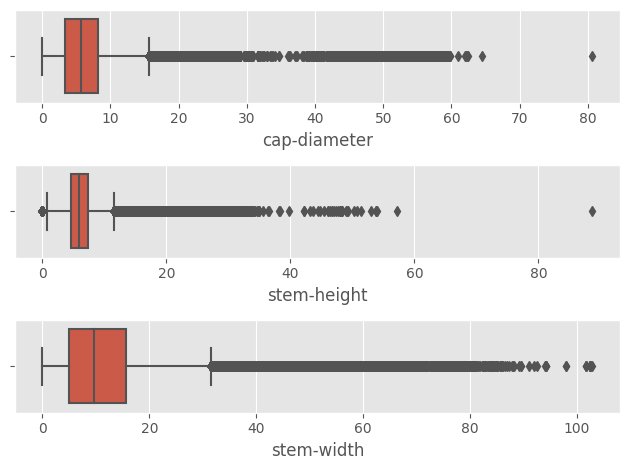

In [21]:
plt.subplot(3, 1, 1)
sns.boxplot(x=train_df['cap-diameter'])

plt.subplot(3, 1, 2)
sns.boxplot(x=train_df['stem-height'])

plt.subplot(3, 1, 3)
sns.boxplot(x=train_df['stem-width'])

plt.tight_layout()
plt.show()

As we see above there are some outliers in our data. We will use 1.5 IQR method to determine whether data point is a outlier or not.

In [22]:
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    mask = (df[col] >= lower_bound) & (df[col] <= upper_bound)
    
    df = df[mask]
    
    return df

In [23]:
train_df_cleaned = df[~df['class'].isna()]
test_df_cleaned = df[df['class'].isna()]

In [24]:
outlier_cols = ['stem-width', 'stem-height', 'cap-diameter']

for col in outlier_cols:
    train_df_cleaned = remove_outliers(train_df_cleaned, col)

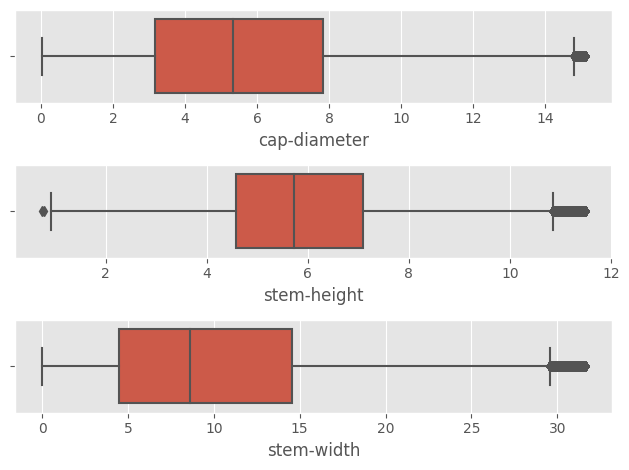

In [25]:
plt.subplot(3, 1, 1)
sns.boxplot(x=train_df_cleaned['cap-diameter'])

plt.subplot(3, 1, 2)
sns.boxplot(x=train_df_cleaned['stem-height'])

plt.subplot(3, 1, 3)
sns.boxplot(x=train_df_cleaned['stem-width'])

plt.tight_layout()
plt.show()

In [26]:
df = pd.concat([train_df_cleaned, test_df_cleaned], axis=0)

Now our dataset is clean and ready to further work.

## 5. Exploratory data analysis

In [27]:
train_df_cleaned.head(1)

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season,class
0,8.8,f,s,u,f,a,w,4.51,15.39,w,f,f,d,a,e


In [28]:
num_cols = df.select_dtypes(exclude='object').columns
cat_cols = df.select_dtypes(include='object').columns

cat_cols = cat_cols.drop(['class'])

In [29]:
subs = int(len(train_df_cleaned) * 0.005)
train_df_subs = train_df_cleaned.iloc[:subs, :]

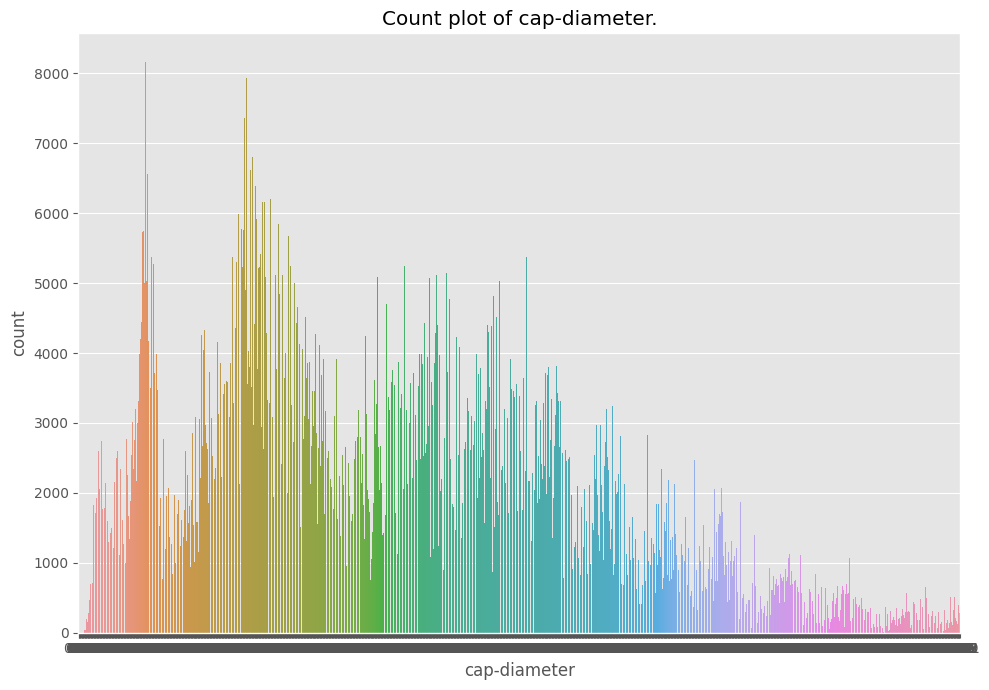

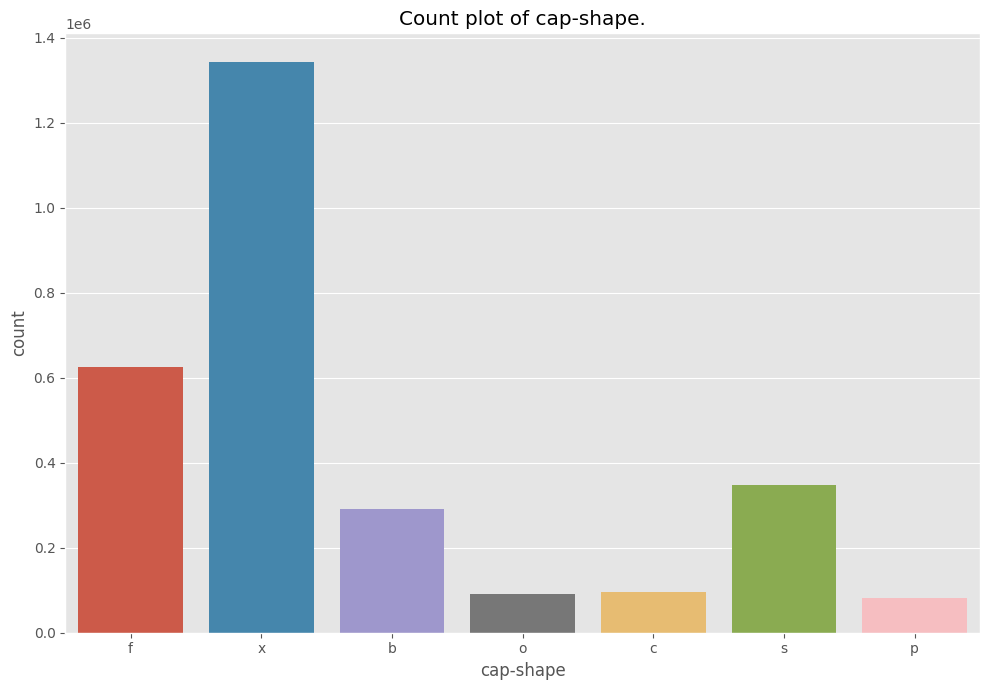

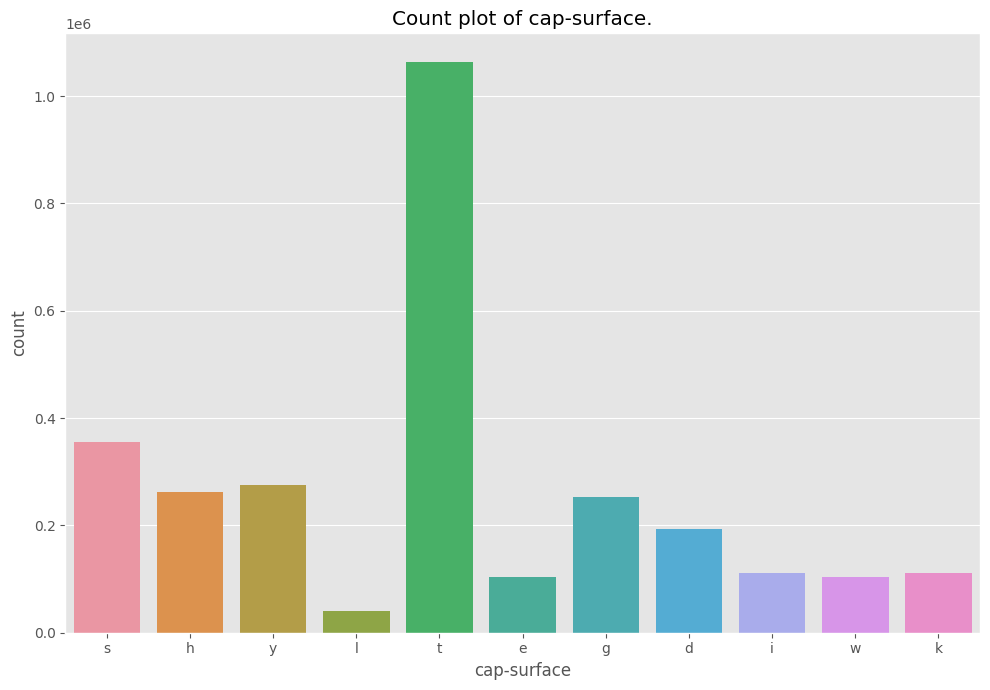

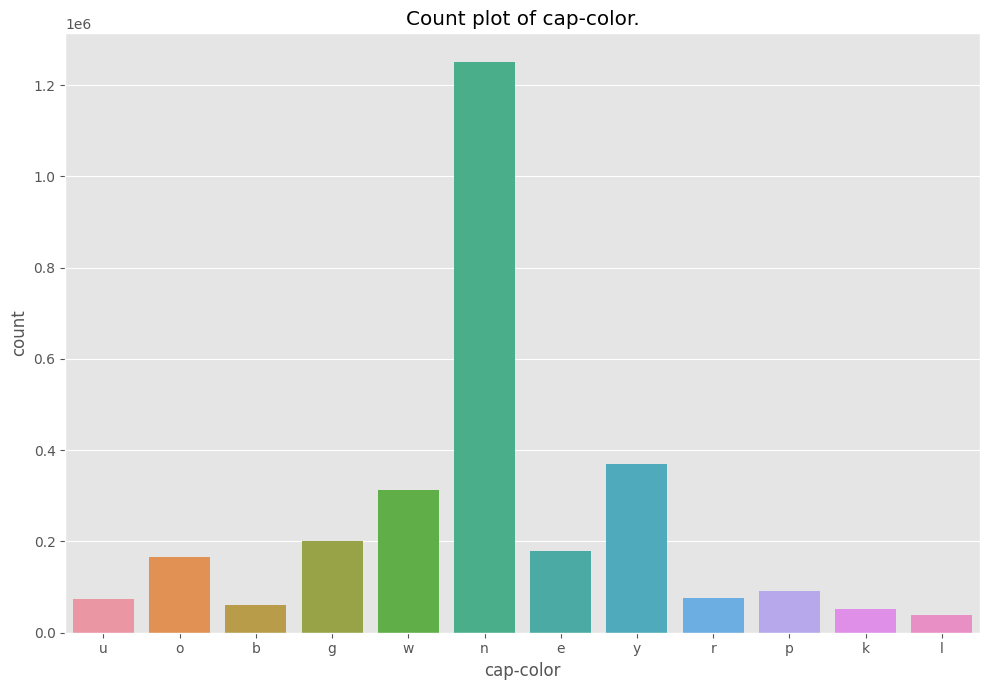

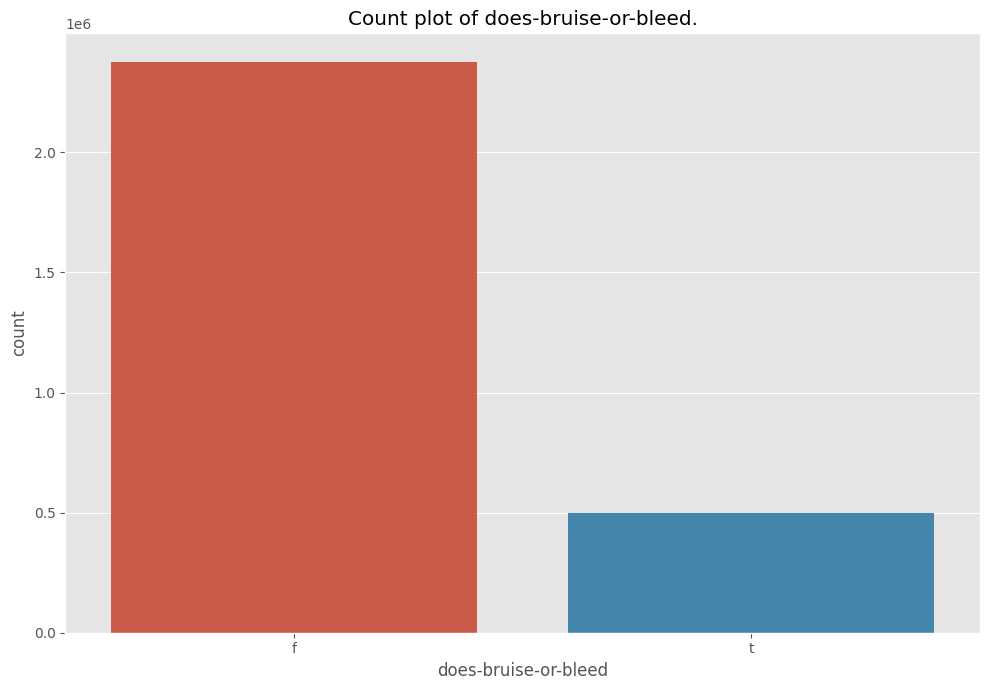

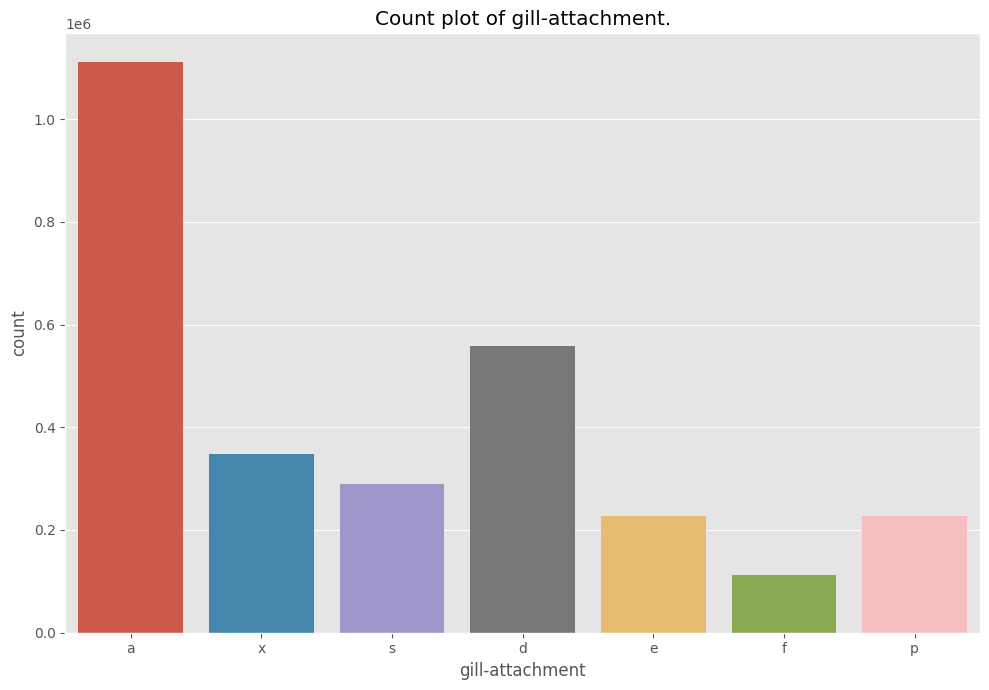

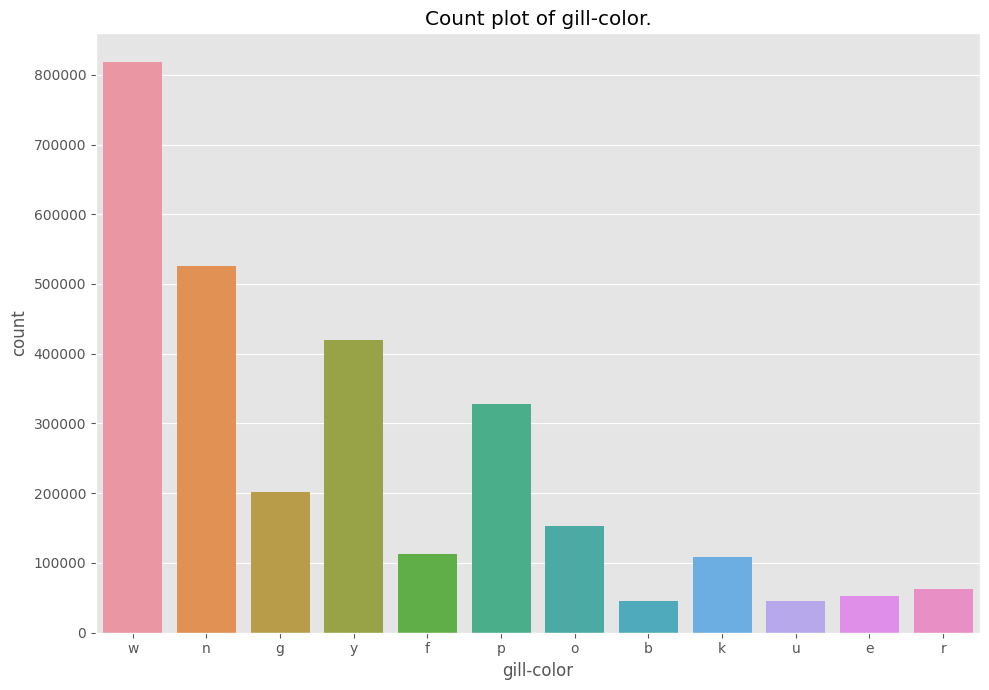

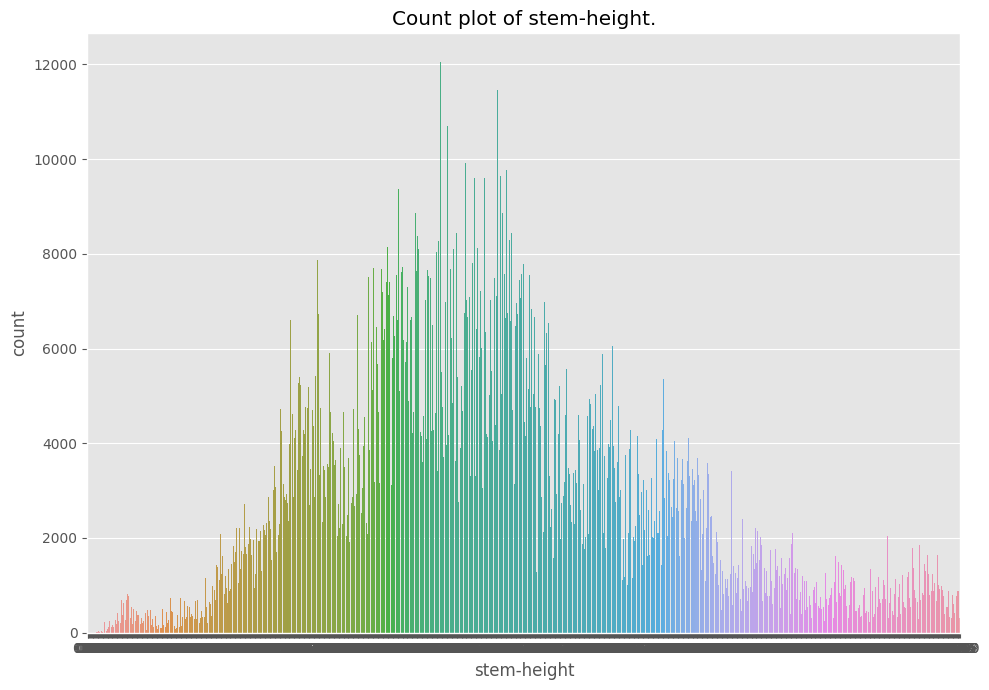

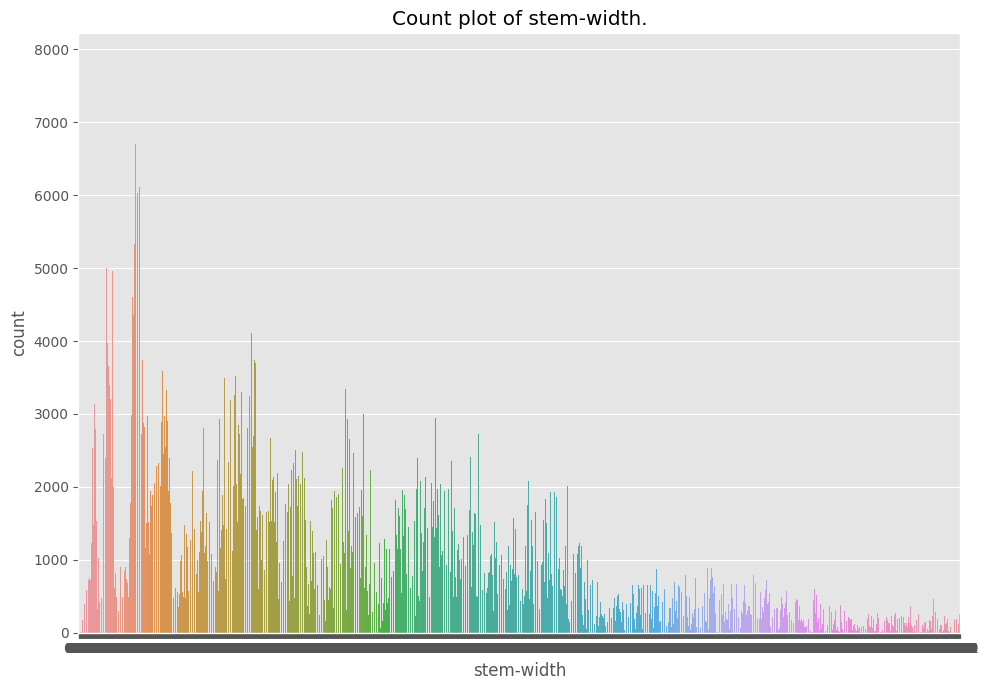

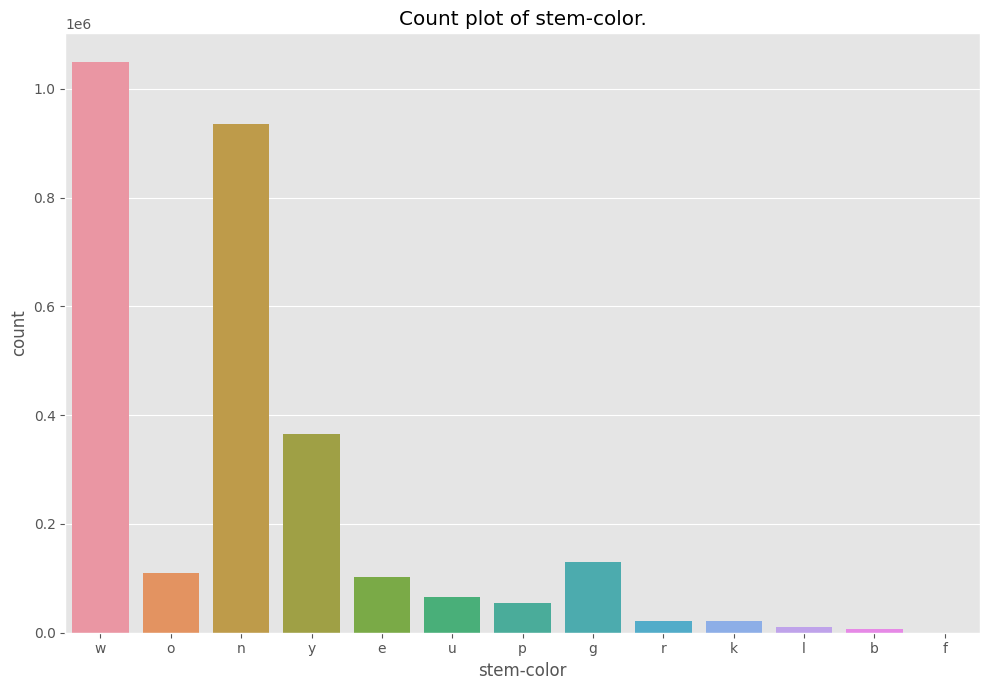

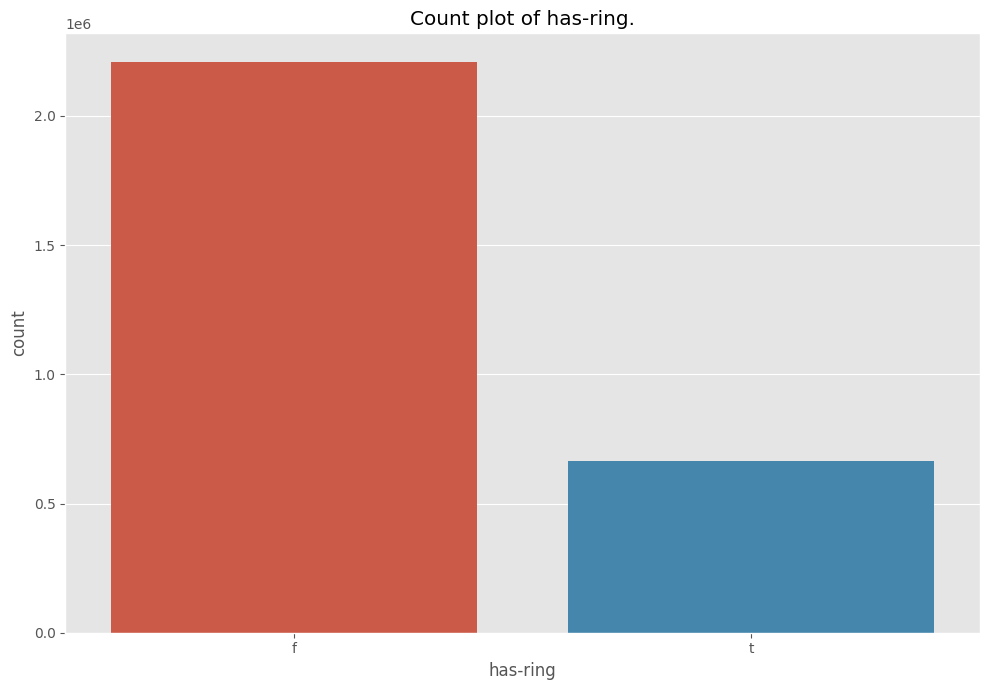

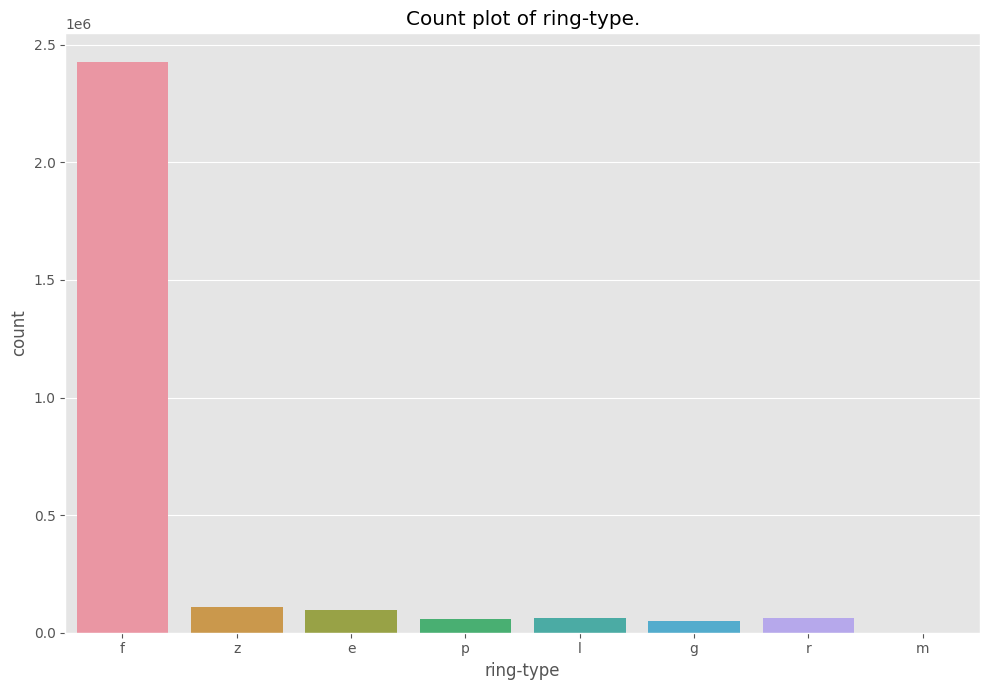

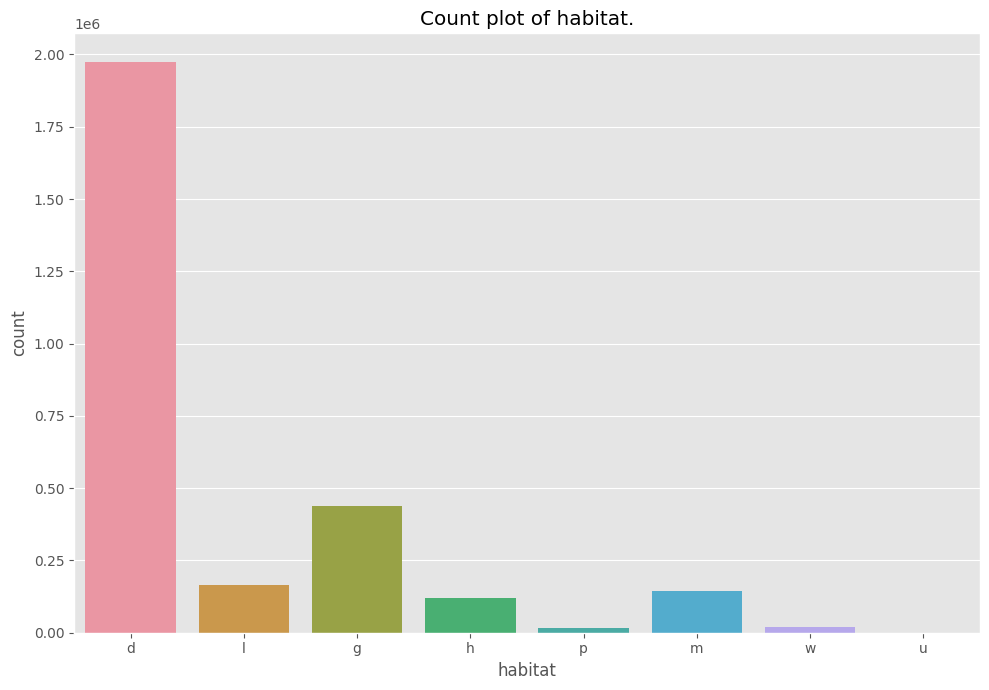

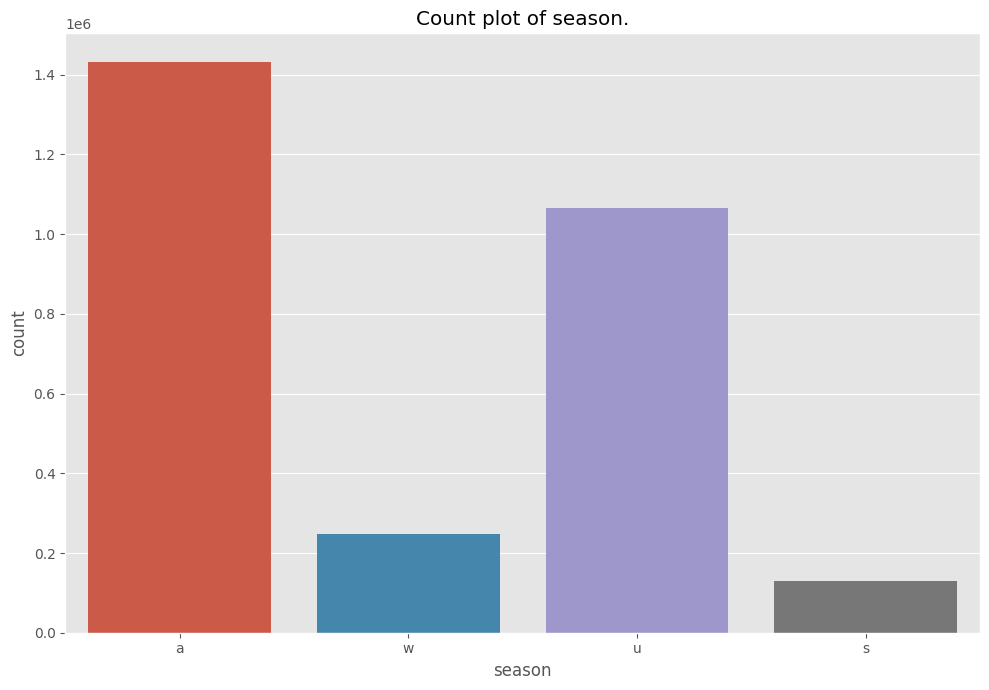

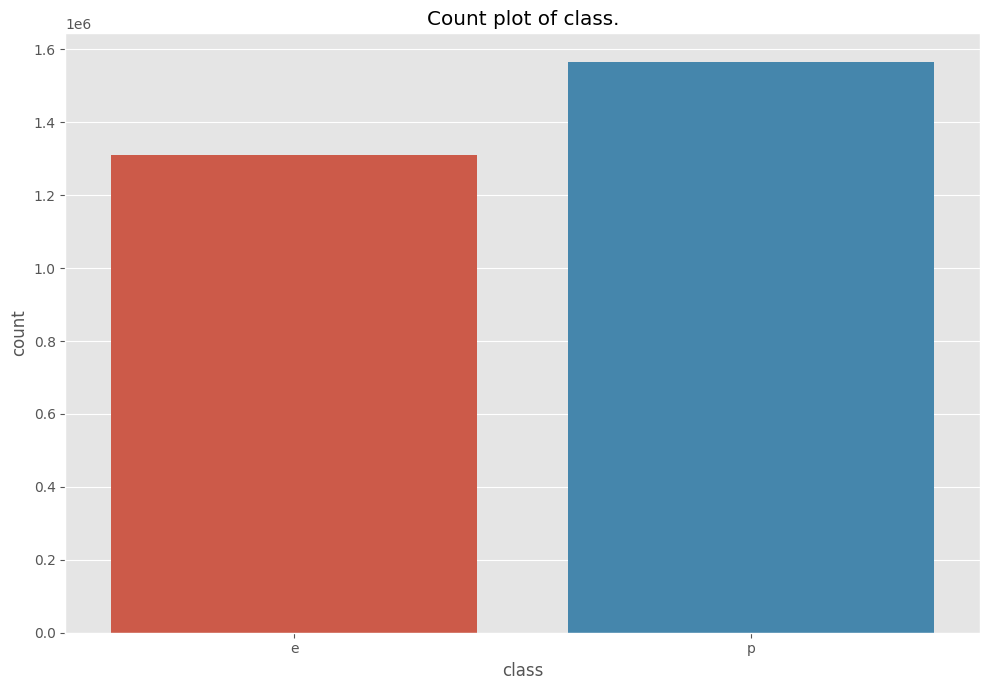

In [30]:
for col in train_df_cleaned.columns:
    plt.figure(figsize=(10, 7))
    sns.countplot(x=train_df_cleaned[col])
    plt.title(f'Count plot of {col}.')
    plt.tight_layout()
    plt.show()

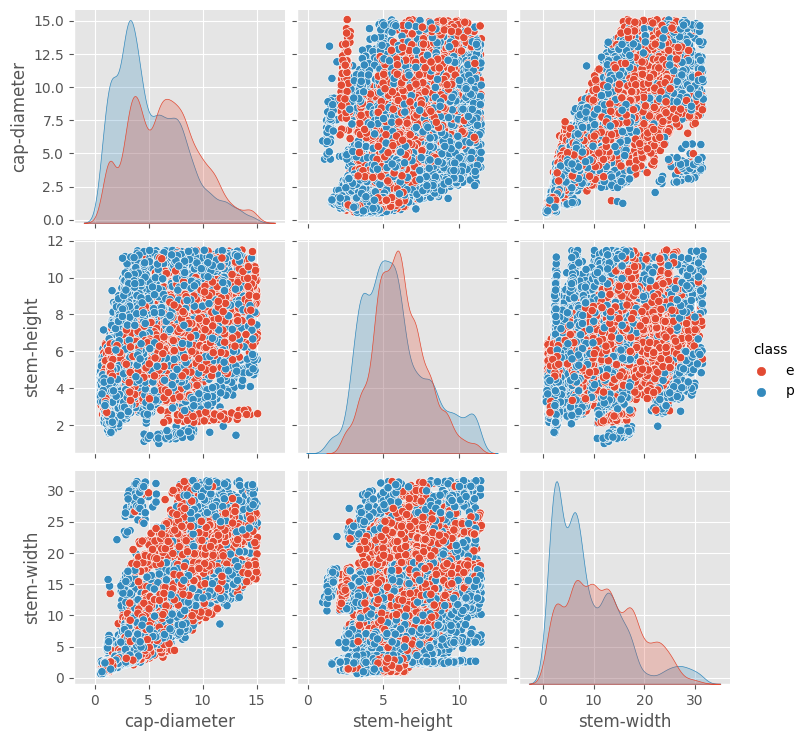

In [31]:
sns.pairplot(data=train_df_subs, hue='class')
plt.show()

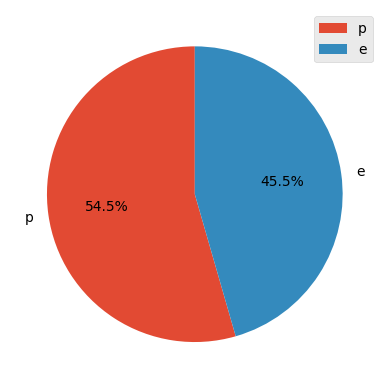

In [32]:
classes = train_df_cleaned['class'].value_counts()

plt.pie(x=classes, labels=classes.index, autopct='%1.1f%%', startangle=90)
plt.legend()
plt.show()

In [46]:
# I have given up on scaling the data because of the focus on tree models

# num_pipeline = Pipeline(steps=[('scl', StandardScaler())])

# cat_pipeline = Pipeline(steps=[('enc', OrdinalEncoder()), ('scl', StandardScaler())])

# preprocessor = ColumnTransformer(transformers=[
#                                     ('num', num_pipeline, num_cols), 
#                                     ('cat', cat_pipeline, cat_cols)])

cat_pipeline = Pipeline(steps=[('enc', OrdinalEncoder())])

preprocessor = ColumnTransformer(transformers=[('cat', cat_pipeline, cat_cols)],
                                 remainder='passthrough')

train_df_preproc = preprocessor.fit_transform(train_df_cleaned)
test_df_preproc = preprocessor.fit_transform(test_df_cleaned)

In [47]:
cols = train_df_cleaned.columns
# cols = cols.drop('class')

In [48]:
train_df_preproc.shape, train_df_cleaned.shape

((2874525, 15), (2874525, 15))

In [49]:
X_train = pd.DataFrame(train_df_preproc, columns=cols)
X_train.drop('class', axis=1, inplace=True)

In [50]:
X_train = X_train.apply(pd.to_numeric, errors='coerce')

In [51]:
X_train.describe()

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
count,2.874525e+06,2.874525e+06,2.874525e+06,2.874525e+06,2.874525e+06,2.874525e+06,2.874525e+06,2.874525e+06,2.874525e+06,2.874525e+06,2.874525e+06,2.874525e+06,2.874525e+06,2.874525e+06
mean,4.083822e+00,6.032656e+00,6.004605e+00,1.731483e-01,2.017425e+00,7.258543e+00,8.429526e+00,2.313676e-01,1.454311e+00,6.807020e-01,1.044659e+00,5.672322e+00,5.927705e+00,1.015639e+01
std,2.191818e+00,3.034046e+00,3.070798e+00,3.783755e-01,2.222981e+00,3.097620e+00,3.126136e+00,4.217069e-01,1.488438e+00,1.276112e+00,1.100759e+00,3.164363e+00,1.969462e+00,6.929730e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e-02,7.400000e-01,0.000000e+00
25%,2.000000e+00,3.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,6.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,3.180000e+00,4.580000e+00,4.510000e+00
50%,5.000000e+00,8.000000e+00,5.000000e+00,0.000000e+00,1.000000e+00,7.000000e+00,1.000000e+01,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,5.340000e+00,5.720000e+00,8.640000e+00
75%,6.000000e+00,8.000000e+00,9.000000e+00,0.000000e+00,4.000000e+00,1.000000e+01,1.100000e+01,0.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,7.830000e+00,7.090000e+00,1.454000e+01
max,6.000000e+00,1.000000e+01,1.100000e+01,1.000000e+00,6.000000e+00,1.100000e+01,1.200000e+01,1.000000e+00,7.000000e+00,7.000000e+00,3.000000e+00,1.511000e+01,1.149000e+01,3.162000e+01


In [52]:
train_df_clnd_scld = pd.DataFrame(X_train, columns=train_df_cleaned.columns)

In [53]:
label_enc = LabelEncoder()
y_train = label_enc.fit_transform(train_df_cleaned['class'])

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## 6. Model

In [55]:
models = {
    'CatBoost' : CatBoostClassifier(verbose=0),
    'LGBM' : LGBMClassifier(),
    'XGB' : XGBClassifier()
}

for name, model in models.items():
    score = cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1, scoring='accuracy')
    print(f'{name} accuracy: {np.mean(score)}')

CatBoost accuracy: 0.9880271523121211
[LightGBM] [Info] Number of positive: 1001147, number of negative: 838549
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.437709 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 1839696, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.544192 -> initscore=0.177229
[LightGBM] [Info] Start training from score 0.177229
LGBM accuracy: 0.9818448265365582
XGB accuracy: 0.987127438446352


In [56]:
cls = CatBoostClassifier(verbose=0)

In [57]:
cls.fit(X_train, y_train)

In [58]:
val_preds = cls.predict(X_test)

In [63]:
print(classification_report(y_test, val_preds))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    260779
           1       0.99      0.99      0.99    314126

    accuracy                           0.99    574905
   macro avg       0.99      0.99      0.99    574905
weighted avg       0.99      0.99      0.99    574905



In [60]:
preds = cls.predict(test_df_preproc)

In [61]:
preds = label_enc.inverse_transform(preds)

In [62]:
submission = pd.DataFrame({'id' : test_df['id'], 'class' : preds})

submission.to_csv('submission.csv', index=False)